In [1]:
%%shell
pip install pytorch-lightning --quiet
pip install wandb --quiet
pip install hydra-core --upgrade --quiet
pip install unzip --quiet
pip install ipdb -Uqq

     |████████████████████████████████| 800 kB 5.0 MB/s 
     |████████████████████████████████| 125 kB 51.8 MB/s 
     |████████████████████████████████| 512 kB 68.1 MB/s 
     |████████████████████████████████| 1.9 MB 4.3 MB/s 
     |████████████████████████████████| 182 kB 6.9 MB/s 
     |████████████████████████████████| 168 kB 26.1 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 168 kB 50.3 MB/s 
     |████████████████████████████████| 166 kB 50.1 MB/s 
     |████████████████████████████████| 166 kB 24.5 MB/s 
     |████████████████████████████████| 162 kB 16.5 MB/s 
     |████████████████████████████████| 162 kB 24.0 MB/s 
     |████████████████████████████████| 158 kB 14.5 MB/s 
     |████████████████████████████████| 157 kB 23.8 MB/s 
     |████████████████████████████████| 157 kB 31.9 MB/s 
     |████████████████████████████████| 157 kB 26.8 MB/s 
     |████████████████████████████████| 157 kB 32.1 MB/s 
     |█████████████

In [82]:
# standardowe pakiety
import os
from os.path import join, isfile
from os import listdir
import numpy as np
from scipy.io import loadmat
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import glob
import ipdb
from __future__ import print_function
from tqdm import tqdm

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torch.utils.data as data
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToPILImage, Normalize, Resize, ToTensor
from torch.autograd import Variable

# Pytorch Lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics

# Hydra
import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

# Weights and Biases
import wandb

In [3]:
! wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2022-12-13 14:38:50--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2022-12-13 14:38:51--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  24.0MB/s    in 78s     

2022-12-13 14:40:09 (24.9 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [10]:
%%shell
cd /content/
mkdir model
unzip -qq /content/ModelNet40.zip -d /content/model

mkdir: cannot create directory ‘model’: File exists
replace /content/model/ModelNet40/stairs/train/stairs_0011.off? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

CalledProcessError: ignored

#DEFAULT LOADER AND READER

In [83]:
def default_loader(path, numpoints):
    myF = open(path, 'r')
    firstLine = myF.readline().strip()
    if 'OFF' != firstLine[0:3]:
        raise ValueError('Not a valid OFF header')
    if len(firstLine) > 3:
        n_verts, n_faces, n_edges = tuple([int(s) for s in firstLine[4:].split(' ')])
    else:
        n_verts, n_faces, n_edges = tuple([int(s) for s in myF.readline().strip().split(' ')])
    verts = torch.tensor([[float(s) for s in myF.readline().strip().split(' ')] for i_vert in range(n_verts)])
    #ipdb.set_trace(context=5)#
    if verts.shape[0] > 0:
      choice = np.random.choice(verts.shape[0], numpoints, replace=True)
      point_set = verts[choice, :]
    else:
      point_set=verts 
    #faces = [[int(s) for s in myF.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return point_set

def default_flist_reader(flist):
    imlist = []
    main_data_folder_string = "./model/ModelNet40/"

    classes_dirs = glob.glob(main_data_folder_string + "*/", recursive = False)
    classes_list = [i.split('/')[3] for i in classes_dirs]
    classes_nums = np.linspace(0,39,40)
    classes_dict = dict(zip(sorted(classes_list), classes_nums.astype(int)))

    for line in flist:
        label_start_index = line.strip().find(main_data_folder_string) + len(main_data_folder_string)
        label_end_index = line.strip()[label_start_index:].find('/')
        imlabel = line.strip()[label_start_index:label_start_index+label_end_index]
        imlabel = classes_dict[imlabel]
        impath = line
        imlist.append( (impath, imlabel) )
    return imlist



#MODELNET FILE LIST

In [55]:
del data

In [84]:
class ModelNetFileList(data.Dataset):
    def __init__(self, root, flist, numpoints, transform=None, target_transform=None, flist_reader=default_flist_reader, loader=default_loader):
        self.root = root
        self.imlist = flist_reader(flist)		
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.numpoints = numpoints

    def __getitem__(self, index):
        impath, target = self.imlist[index]
        obj = self.loader(impath, self.numpoints)
        return obj, target

    def __len__(self):
      return len(self.imlist)

#MODELNET DATA MODULE

#LOAD SAMPLE DATA

Rozmiar zbioru treningowego: 8858
Rozmiar zbioru walidacyjnego: 985
Rozmiar zbioru testowego: 2468


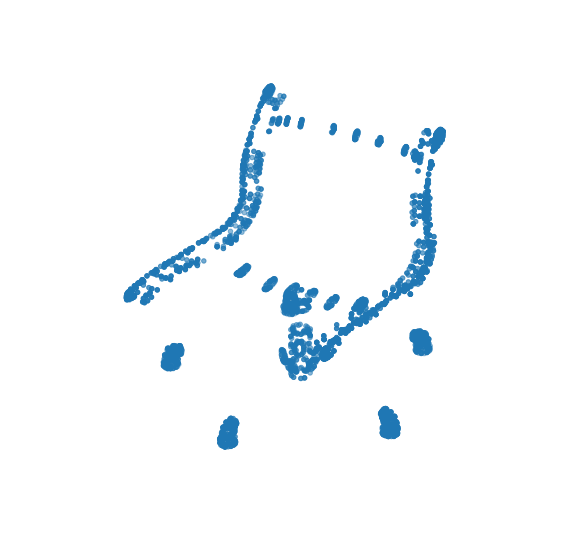

Etykieta klasy: 8



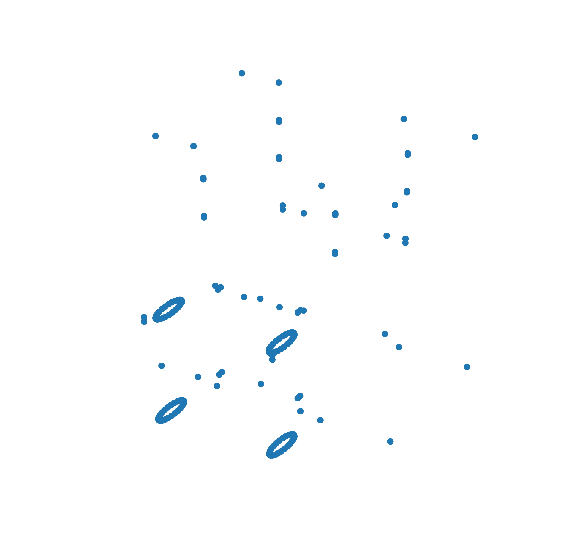

Etykieta klasy: 4



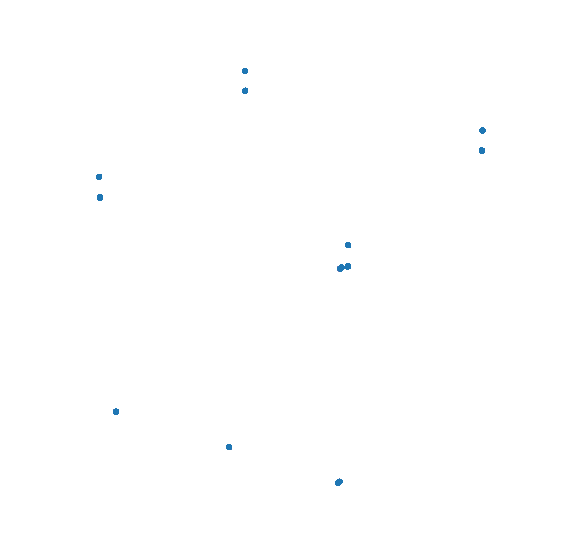

Etykieta klasy: 33



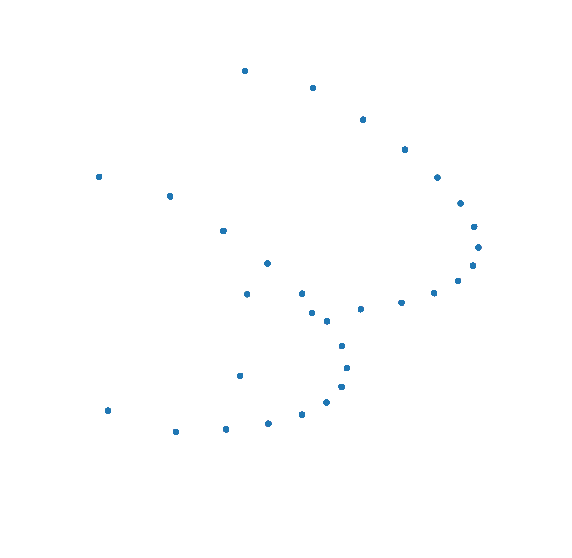

Etykieta klasy: 22



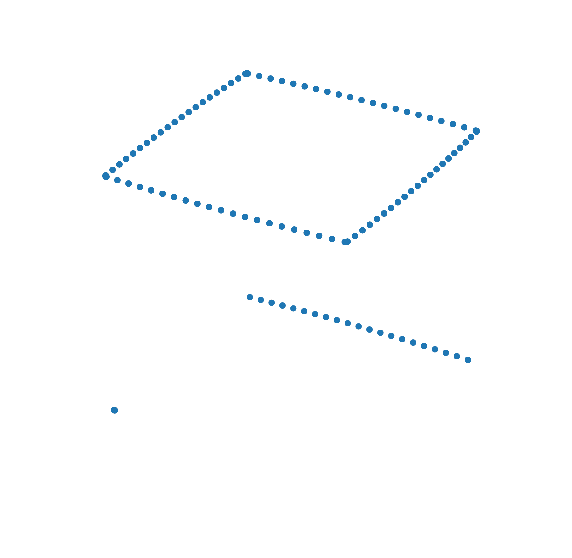

Etykieta klasy: 33



In [18]:
sample_data = ModelNetDataModule(batch_size=10, npoints=4000)
sample_data.setup()
sample_data.prepare_batch()

print("Rozmiar zbioru treningowego: " + str(len(sample_data.train_dataset)))
print("Rozmiar zbioru walidacyjnego: " + str(len(sample_data.val_dataset)))
print("Rozmiar zbioru testowego: " + str(len(sample_data.test_dataset)))


def show_examples(dataset, n):
    for i in range(n):
        tensor_image, target = random.choice(dataset)
        #ipdb.set_trace(context=5)
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(projection='3d')
        V_np = np.asarray(tensor_image)

        #print(V_np.size)
        #print(V_np)
        xx = V_np[:, 0]
        yy = V_np[:, 1]
        zz = V_np[:, 2]
        ax.scatter(xx, yy, zz)
        plt.axis('off')
        plt.show()

        print('Etykieta klasy: {}'.format(target))
        print()
  
show_examples(sample_data.train_dataset, 5)

#dir(sample_data)

#STN3D

In [19]:
class STN3d(nn.Module):
    def __init__(self, channel=3):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64) #To jest ta normalizacja odchylenia i sredniej (?)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        # chodzi o to, żeby tutaj wchodził tensor [Batchsize x 3 x Length]
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024) #to jest jakiś resize...(?2)
        x = F.relu(self.bn4(self.fc1(x))) # próba na batch_size=1. Jak się nie wywali z tego etapu batchnormów to wywala błąd "Error: Expected more than 1 value per channel when training"
        x = F.relu(self.bn5(self.fc2(x)))
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


#STNKD

In [20]:
class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.shape[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

#POINTNET FEATURE

In [21]:
class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.shape[2]
        trans = self.stn(x)
        #ipdb.set_trace(context=5)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat


def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

#POINTNET CLS

In [22]:
class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat

In [ ]:
stn=STN3d()
dataTrans=stn.forward(sample_data.batch_tensor)

In [ ]:
pointnetfeat = PointNetfeat(feature_transform = True)
dataTrans = pointnetfeat.forward(sample_data.batch_tensor)

#data=torch.rand(5,3,1000)


In [ ]:
pointnetcls = PointNetCls()
dataTrans2 = pointnetcls.forward(sample_data.batch_tensor)

In [ ]:
print(dataTrans[0].shape)
print(dataTrans[0].dtype)
print(dataTrans[1].shape)
print(dataTrans[1].dtype)
print(dataTrans[2].shape)
print(dataTrans[2].dtype)

torch.Size([10, 1024])
torch.float32
torch.Size([10, 3, 3])
torch.float32
torch.Size([10, 64, 64])
torch.float32


In [23]:
! nvidia-smi

Tue Dec 13 14:43:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#TRENOWANIE

In [85]:


class ModelNetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, npoints=100, data_dir: str = './model/ModelNet40/'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = 40
        self.npoints = npoints
        self.imglist = [f1 for f1 in glob.glob(data_dir + '**/*.off', recursive=True)]# if isfile(join(self.data_dir, f1))]
        self.trainlist = [f2 for f2 in self.imglist if "train" in f2]
        self.testlist = [f3 for f3 in self.imglist if "test" in f3]


    def setup(self, stage=None):
        #training / validation
        if stage == 'fit' or stage is None:
            train_dataset = ModelNetFileList(root=self.data_dir, numpoints=self.npoints, flist=self.trainlist)
            train_dataset_size = int(len(train_dataset) * 0.9)
            self.train_dataset, self.val_dataset = random_split(train_dataset, [train_dataset_size, len(train_dataset) - train_dataset_size])
        #testing
        if stage == 'test' or stage is None:
            self.test_dataset = ModelNetFileList(root=self.data_dir, numpoints=self.npoints, flist=self.testlist)

    def prepare_batch(self):
        batch_tensor = torch.empty((self.batch_size, 3, self.npoints))
        for n in range(self.batch_size):
            obj, target = random.choice(self.train_dataset) 
            obj = obj.view(obj.shape[1], obj.shape[0])
            batch_tensor[n, :, :] = obj
        self.batch_tensor = batch_tensor

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)
        
    def __len__(self):
        return len(self.train_dataset)

In [86]:
#ipdb.set_trace(context=5)
#parser = argparse.ArgumentParser()
#parser.add_argument(
#    '--batchSize', type=int, default=32, help='input batch size')
#parser.add_argument(
#    '--num_points', type=int, default=2500, help='input batch size')
#parser.add_argument(
#    '--workers', type=int, help='number of data loading workers', default=4)
#parser.add_argument(
#    '--nepoch', type=int, default=250, help='number of epochs to train for')
#parser.add_argument('--outf', type=str, default='cls', help='output folder')
#parser.add_argument('--model', type=str, default='', help='model path')
#parser.add_argument('--dataset', type=str, required=True, help="dataset path")
#parser.add_argument('--dataset_type', type=str, default='shapenet', help="dataset type shapenet|modelnet40")
#parser.add_argument('--feature_transform', action='store_true', help="use feature transform")

#ipdb.set_trace(context=5)
#parser = argparse.ArgumentParser()


#opt = parser.parse_args()

class opt:
  pass

opt.batchSize=32
opt.num_points=2500
opt.workers=4
opt.nepoch=3
opt.outf='cls'
opt.model=''
opt.dataset='./model/ModelNet40/'
opt.dataset_type='modelnet'
opt.feature_transform='store_true'


print(opt)

blue = lambda x: '\033[94m' + x + '\033[0m'

opt.manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

dataset = ModelNetDataModule(npoints=opt.num_points, batch_size=opt.batchSize)

test_dataset = ModelNetDataModule(npoints=opt.num_points, batch_size=opt.batchSize)
dataset.setup()
test_dataset.setup()
'''
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batchSize,
    shuffle=True,
    num_workers=int(opt.workers))

testdataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=opt.batchSize,
        shuffle=True,
        num_workers=int(opt.workers))
'''

dataloader = dataset.train_dataloader()
testdataloader = dataset.test_dataloader()


print(len(dataloader), len(testdataloader))
num_classes = dataset.num_classes
print('classes', num_classes)

try:
    os.makedirs(opt.outf)
except OSError:
    pass

classifier = PointNetCls(k=num_classes, feature_transform=opt.feature_transform)

if opt.model != '':
    classifier.load_state_dict(torch.load(opt.model))



optimizer = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
classifier.cuda()

#ipdb.set_trace(context=5)#
num_batch = 8858 / opt.batchSize #pierdole to hardkoduje


for epoch in range(opt.nepoch):
    scheduler.step()
    for i, data in enumerate(dataloader, 0):
        #ipdb.set_trace(context=5)#
        points, target = data
        points=points.permute(0,2,1)
        #points.permuter
        #points = dataset.prepare_batch() #tu gdzieś powinno być prepare_batch, które jest funkcją ModelNetDataModule (nazwa zmiennej dataset). Może trzeba przenieść funkcję do Datamodule, idk
        target = target.reshape(32,1)
        points = points.transpose(2, 1)
        points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.train()
        #ipdb.set_trace(context=5)#
        points=points.permute(0,2,1)
        pred, trans, trans_feat = classifier(points)
        #ipdb.set_trace(context=5)#
        target= target.reshape(32)
        loss = F.nll_loss(pred, target)
        if opt.feature_transform:
            loss += feature_transform_regularizer(trans_feat) * 0.001
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' % (epoch, i, num_batch, loss.item(), correct.item() / float(opt.batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            #target = target[:, 0]
            points = points.transpose(2, 1)
            points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' % (epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(opt.batchSize)))

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (opt.outf, epoch))

total_correct = 0
total_testset = 0
for i,data in tqdm(enumerate(testdataloader, 0)):
    points, target = data
    target = target[:, 0]
    points = points.transpose(2, 1)
    points, target = points.cuda(), target.cuda()
    classifier = classifier.eval()
    pred, _, _ = classifier(points)
    pred_choice = pred.data.max(1)[1]
    correct = pred_choice.eq(target.data).cpu().sum()
    total_correct += correct.item()
    total_testset += points.size()[0]

print("final accuracy {}".format(total_correct / float(total_testset)))

<class '__main__.opt'>
Random Seed:  2103
277 78
classes 40


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[0: 0/276] train loss: 3.900262 accuracy: 0.000000
[0: 0/276] test loss: 3.713514 accuracy: 0.000000
[0: 1/276] train loss: 3.896873 accuracy: 0.000000
[0: 2/276] train loss: 3.836653 accuracy: 0.062500
[0: 3/276] train loss: 3.700596 accuracy: 0.031250
[0: 4/276] train loss: 4.010932 accuracy: 0.031250
[0: 5/276] train loss: 3.974408 accuracy: 0.062500
[0: 6/276] train loss: 3.890864 accuracy: 0.062500
[0: 7/276] train loss: 3.975628 accuracy: 0.031250
[0: 8/276] train loss: 3.857252 accuracy: 0.000000
[0: 9/276] train loss: 3.728204 accuracy: 0.125000
[0: 10/276] train loss: 4.032708 accuracy: 0.062500
[0: 10/276] test loss: 3.704397 accuracy: 0.000000
[0: 11/276] train loss: 3.840245 accuracy: 0.031250
[0: 12/276] train loss: 3.858330 accuracy: 0.093750
[0: 13/276] train loss: 3.959757 accuracy: 0.093750
[0: 14/276] train loss: 3.934900 accuracy: 0.125000
[0: 15/276] train loss: 3.855449 accuracy: 0.062500
[0: 16/276] train loss: 3.991107 accuracy: 0.000000
[0: 17/276] train loss: 3

RuntimeError: ignored

In [ ]:
a = torch.rand(8,2)
b = torch.rand(8,4)
c = torch.rand(8,6)

aa = []
aa.append(a)
aa.append(b)
aa.append(c)

d = torch.cat((a,b,c), dim=1)
e = torch.reshape(d, (8,3,-1))

cnn1 = torch.nn.Conv1d(3, 64, 1)
out = cnn1(e)

```python
class STN3d(nn.Module):
  output:
    stn torch.Size([32, 3, 3])global feat torch.Size([32, 1024])classification head:
      global feat torch.Size([32, 1024])
      point feat torch.Size([32, 1088, 2500])
      class torch.Size([32, 5])segmentation head:
        PointNetDenseCls(
          (feat): PointNetfeat(
            (stn): STN3d(
              (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
              (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
              (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
              (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
              (fc1): Linear(in_features=1024, out_features=512, bias=True)
              (fc2): Linear(in_features=512, out_features=256, bias=True)
              (fc3): Linear(in_features=256, out_features=9, bias=True)
              (relu): ReLU()
              (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
            (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
            (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
            (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
          )
          (conv1): Conv1d(1088, 512, kernel_size=(1,), stride=(1,))
          (conv2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
          (conv3): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
          (conv4): Conv1d(128, 3, kernel_size=(1,), stride=(1,))
          (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
  seg torch.Size([32, 2500, 3])
```